In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')
import picea
picea.__version__,picea

('0.0.18', <module 'picea' from '../picea/__init__.py'>)

In [2]:
from picea import Tree

In [3]:
tree = Tree.from_newick(filename='./data/tree.newick')
print(tree.to_json(indent=2))

{
  "name": "",
  "length": 0.0,
  "children": [
    {
      "name": "Eucgr.J03126.1",
      "length": 0.096360892,
      "children": []
    },
    {
      "name": "1.000",
      "length": 0.159121648,
      "children": [
        {
          "name": "Eucgr.F03978.1",
          "length": 0.022217443,
          "children": []
        },
        {
          "name": "0.989",
          "length": 0.033587992,
          "children": [
            {
              "name": "Eucgr.F03972.1",
              "length": 0.049020651,
              "children": []
            },
            {
              "name": "0.992",
              "length": 0.028383846,
              "children": [
                {
                  "name": "Eucgr.F03974.1",
                  "length": 0.016885197,
                  "children": []
                },
                {
                  "name": "Eucgr.F03973.1",
                  "length": 0.031615842,
                  "children": []
                }
              ]

In [4]:
print(tree.iloc[3].parent)

Tree(name='1.000', length=0.159121648, children=[Tree(name='Eucgr.F03978.1', length=0.022217443, children=[]), Tree(name='0.989', length=0.033587992, children=[Tree(name='Eucgr.F03972.1', length=0.049020651, children=[]), Tree(name='0.992', length=0.028383846, children=[Tree(name='Eucgr.F03974.1', length=0.016885197, children=[]), Tree(name='Eucgr.F03973.1', length=0.031615842, children=[])])])])


In [5]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering.labels_


array([1, 1, 1, 0, 0, 0])

In [6]:
tree = Tree(children=[Tree(),Tree()])
for t in tree.depth_first():
    print(t.ID,t.name)

None None
None None
None None


In [7]:
t.iloc[None]

Tree(name=None, length=0.0, children=[])

In [8]:
tree = Tree.from_sklearn(clustering)
tree.to_newick(branch_lengths=False)

'((2,(0,1)),(4,(3,5)));'

In [9]:
Tree(**tree.to_dict())

Tree(name=None, length=0.0, children=[{'name': None, 'length': 0.0, 'children': [{'name': '2', 'length': 0.0, 'children': []}, {'name': None, 'length': 0.0, 'children': [{'name': '0', 'length': 0.0, 'children': []}, {'name': '1', 'length': 0.0, 'children': []}]}]}, {'name': None, 'length': 0.0, 'children': [{'name': '4', 'length': 0.0, 'children': []}, {'name': None, 'length': 0.0, 'children': [{'name': '3', 'length': 0.0, 'children': []}, {'name': '5', 'length': 0.0, 'children': []}]}]}])

In [10]:
tree.iloc[1].name = 'long name'

In [11]:
print(tree.to_json(indent=2))

{
  "name": null,
  "length": 0.0,
  "children": [
    {
      "name": null,
      "length": 0.0,
      "children": [
        {
          "name": "2",
          "length": 0.0,
          "children": []
        },
        {
          "name": null,
          "length": 0.0,
          "children": [
            {
              "name": "0",
              "length": 0.0,
              "children": []
            },
            {
              "name": "long name",
              "length": 0.0,
              "children": []
            }
          ]
        }
      ]
    },
    {
      "name": null,
      "length": 0.0,
      "children": [
        {
          "name": "4",
          "length": 0.0,
          "children": []
        },
        {
          "name": null,
          "length": 0.0,
          "children": [
            {
              "name": "3",
              "length": 0.0,
              "children": []
            },
            {
              "name": "5",
              "length": 0.0,
     

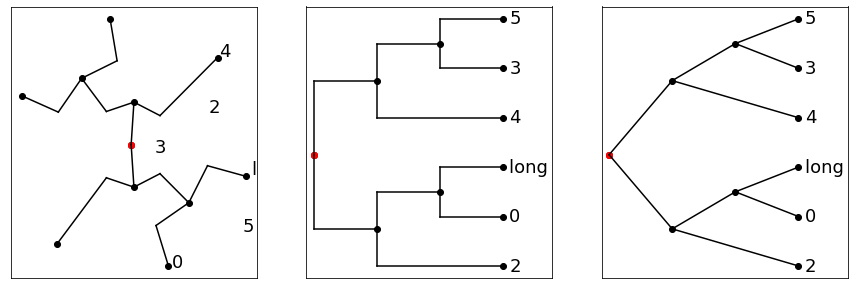

In [12]:
from matplotlib import pyplot as plt
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3,figsize=(15, 5))

picea.treeplot(tree, style='radial', ltr=True, ax=ax1)
picea.treeplot(tree, style='square', ltr=True, ax=ax2)
picea.treeplot(tree, style='triangular', ltr=True, ax=ax3)

for ax in (ax1,ax2,ax3):
    ax.scatter((0,0),(0,0),c='red')


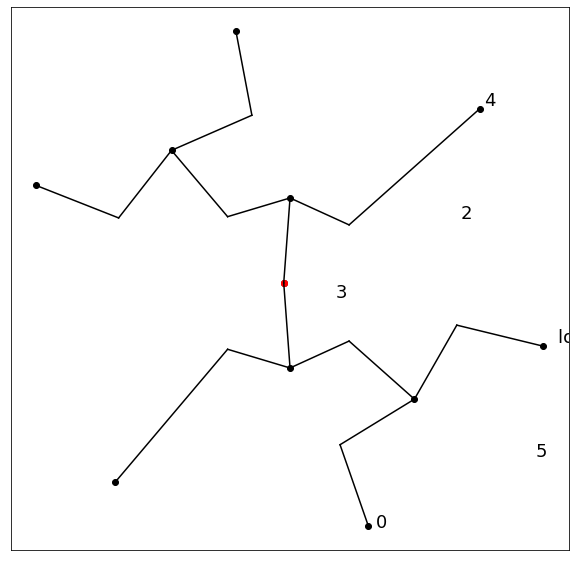

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
picea.treeplot(tree, style='radial', ax=ax)

ax.scatter((0,0),(0,0),c='red')

In [14]:
import numpy as np
from dataclasses import dataclass

@dataclass
class TwoDCoordinate():
    x: float = 0.0
    y: float = 0.0
    
    def __iter__(self):
        yield from (self.x, self.y)
    
    def to_polar(self):
        return TwoDCoordinate(
            x = self.x * np.cos(self.y), 
            y = self.x * np.sin(self.y)
        )
    
    def to_cartesian(self):
        return TwoDCoordinate(
            x = np.sqrt(self.x ** 2 + self.y ** 2),
            y = np.arctan2(self.y, self.x)
        )

c = TwoDCoordinate(x=1, y=1)

c

TwoDCoordinate(x=1, y=1)

In [15]:
c.to_cartesian().to_polar()

TwoDCoordinate(x=1.0000000000000002, y=1.0)

In [16]:
c.to_polar().to_cartesian()

TwoDCoordinate(x=1.0, y=1.0)

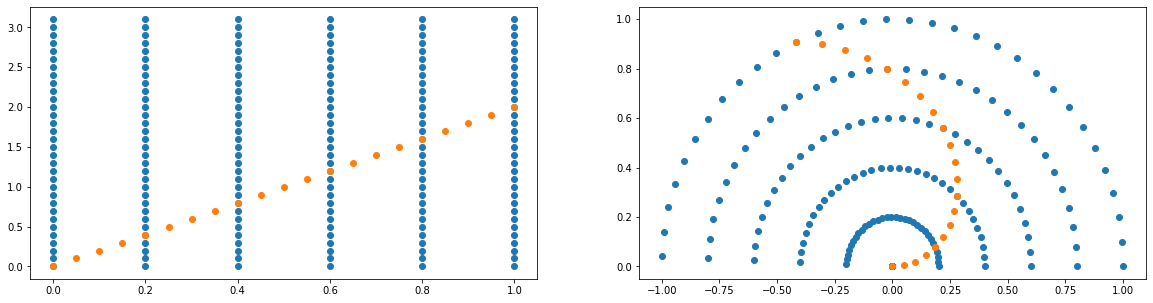

In [17]:
grid = np.array([
    [TwoDCoordinate(x,y) for x in np.arange(0, 1.2, .2)] 
    for y in np.arange(0, np.pi, .1)
]).flatten()

fig,[ax1,ax2] = plt.subplots(ncols=2, figsize=(20,5))


ax1.scatter(*zip(*[[*p] for p in grid]))
ax2.scatter(*zip(*[[*p.to_polar()] for p in grid]))

points = np.array([TwoDCoordinate(x, x*2) for x in np.arange(0., 1.05, .05)])

ax1.scatter(*zip(*[[*p] for p in points]))
ax2.scatter(*zip(*[[*p.to_polar()] for p in points]))

In [18]:
p1.to_polar(),p2.to_polar()

NameError: name 'p1' is not defined

In [ ]:
from matplotlib.patches import Arc

fig,ax = plt.subplots()

arc = Arc( (.5, .5) , width=.5, height=.5, theta1=10, theta2=100)
ax.add_patch(arc)

In [ ]:
layout = picea.calculate_tree_layout(tree,style='radial')
layout

In [ ]:
layout[0].to_cartesian()

In [21]:
import torch
torch.__version__

'1.4.0'